In [2]:

% matplotlib notebook
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener
import math

import json



/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# '''
# relative time v.s. epoch
# '''
# event_file = 'loss_acc_data/loss_acc'
# relative_time = []
# summary = tf.train.summary_iterator(event_file)
# for i, e in enumerate(summary):
#     if i == 0:
#         begin_time = e.wall_time
#     relative_time.append(e.wall_time - begin_time)
#     # print(e)
#     # for v in e.summary.value:
#     #     # print(v)
#     #     if v.tag == 'Relative':
#     #         print(v.simple_value)
# num_epochs = len(relative_time)
# epochs = np.arange(num_epochs)
# plt.figure()

# # with tensorboard
# plt.plot(epochs, relative_time, 'o')
# print(pearsonr(epochs, relative_time))

# # without tensorboard, using time.time()
# with open('time.json') as f: 
#     time_ = json.load(f)
# #     dat = f.read()

# begin = time_[0]
# epoch_time = [(t - begin) for t in time_]
# epochs = np.arange(len(epoch_time))
# plt.plot(epochs, epoch_time, 'x')
# print(pearsonr(epochs, epoch_time))

In [7]:
'''
Loss or Accuracy v.s. epoch
'''
event_file = 'data/train'
# event_file = 'train_sample_100/loss_acc'
loss = []
acc = []
summary = tf.train.summary_iterator(event_file)
for i, e in enumerate(summary):
    for v in e.summary.value:
        if v.tag == 'loss':
            loss.append(v.simple_value)
        if v.tag == 'train_accuracy_1':
            acc.append(v.simple_value)

num_epochs = len(loss)
loss = np.array(loss)
acc = np.array(acc)
err = 1 - acc

epochs = np.arange(1,num_epochs+1)*20
fig = plt.figure()
axes_loss = plt.subplot(311)
axes_acc = plt.subplot(312)
axes_loss.plot(epochs, loss)
axes_loss.set_title('train loss')
axes_acc.plot(epochs, err)
axes_acc.set_title('train error')

print("epoch vs train_loss: {}".format(pearsonr(epochs, loss)))
print("epoch vs train_err: {}".format(pearsonr(epochs, err)))

event_file = 'data/eval'
# event_file = 'val_sample_100/loss_acc'
val_acc = []
summary = tf.train.summary_iterator(event_file)
for i, e in enumerate(summary):
    for v in e.summary.value:
        if v.tag == 'accuracy':
            val_acc.append(v.simple_value)

with open('val_err.json', 'w') as f:
    json.dump(val_acc,f)

val_acc = val_acc[:len(epochs)]
val_acc = np.array(val_acc)
val_err = 1 - val_acc

axes_val_acc = plt.subplot(313)
axes_val_acc.plot(epochs, val_err)
axes_val_acc.set_title('val error')

print("epoch vs val_err: {}".format(pearsonr(epochs, val_err)))

fig.tight_layout()


<IPython.core.display.Javascript object>

epoch vs train_loss: (-0.8109606838436675, 3.416863551782703e-167)
epoch vs train_err: (-0.7852491285176241, 9.533381235784438e-150)


ValueError: x and y must have same first dimension, but have shapes (711,) and (532,)

<IPython.core.display.Javascript object>


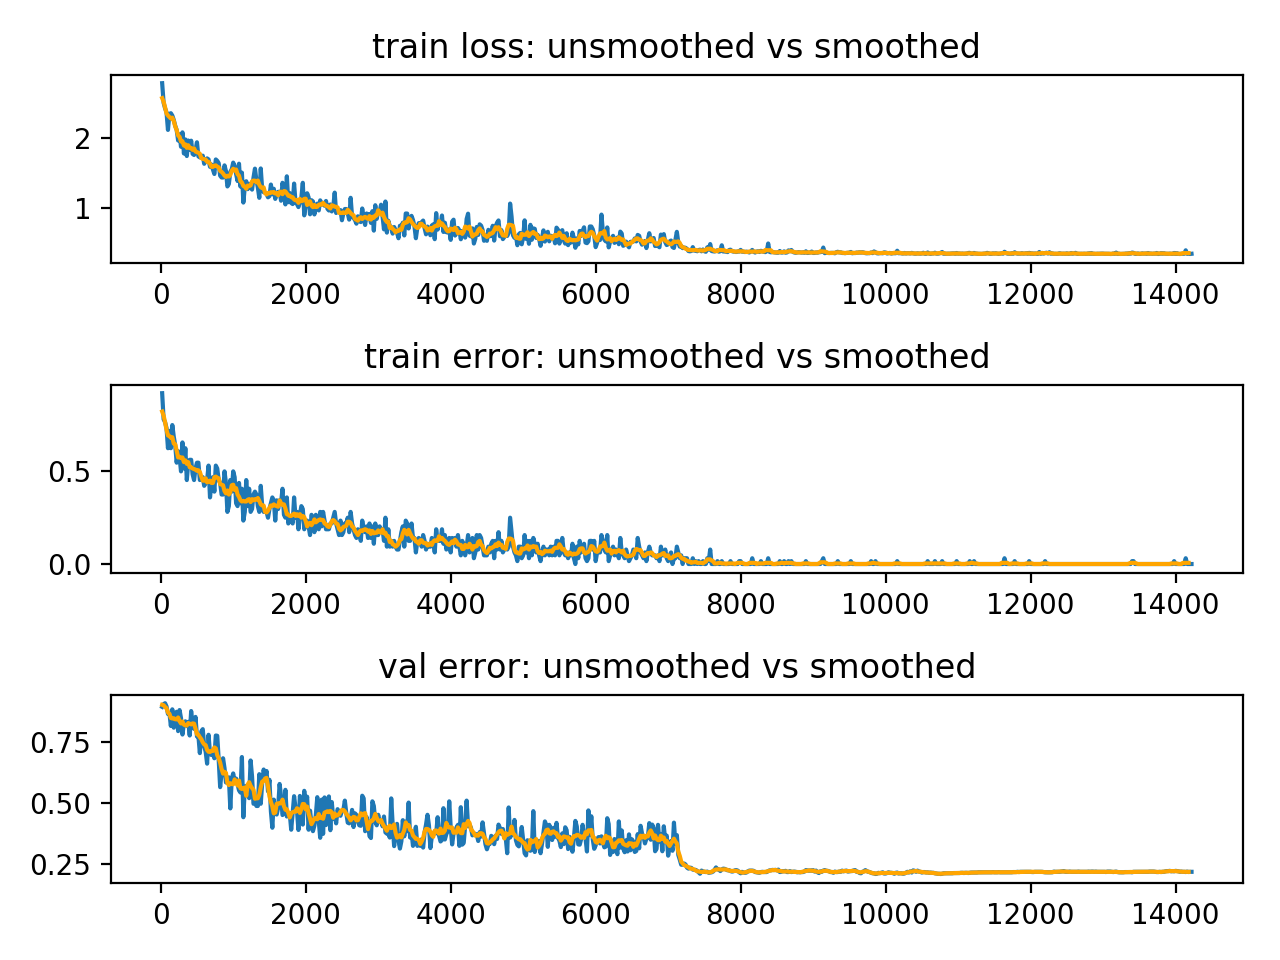

In [4]:
'''
sampling
'''
def sampling(data, sample_period):
    data_sampled = []
#     print(len(data))
    for i in range(math.floor(len(data)/sample_period)):
        index = i*win_size+math.floor(sample_period/2)
#         print(data[index])
        data_sampled.append(data[index])
    return np.array(data_sampled)

'''
smoothing by linear filtering
'''
def smooth_by_linear_filter(data, win_size, win_type='rectangular'):    
    half_win = math.floor(win_size/2)
    total_win = half_win*2+1
    
    if win_type == 'gaussian':
        data_smoothed = gaussian_filter(data, total_win)
        return data_smoothed
    if win_type == 'wiener':
        data_smoothed = wiener(data, total_win)
        return data_smoothed
       
    if win_type == 'rectangular':
        weights = np.ones(total_win)/total_win
    elif win_type == 'hamming':
        weights = np.hamming(total_win)/np.sum(np.hamming(total_win))
    data_smoothed = []
    
#     print(len(data))
    for i in range(len(data)):
        end = i+half_win
        if i+half_win >= len(data):
            break
        if i-half_win < 0:
            start = 0
            data_smoothed.append(np.mean(data[start:end+1]))
        else:
            start = i-half_win
            data_smoothed.append(weights.dot(data[start:end+1].T))
        
#         print(data[start:end+1])
        
    return np.array(data_smoothed)

win_size = 5
win_type = 'rectangular'

loss_smoothed = smooth_by_linear_filter(loss, win_size, win_type=win_type)
err_smoothed = smooth_by_linear_filter(err, win_size, win_type=win_type)
val_err_smoothed = smooth_by_linear_filter(val_err, win_size, win_type=win_type)
epochs_smoothed = np.arange(1, len(loss_smoothed)+1)*20
fig = plt.figure()
axes_loss = plt.subplot(311)
axes_acc = plt.subplot(312)
axes_val_acc = plt.subplot(313)
axes_loss.plot(epochs, loss)
axes_acc.plot(epochs, err)
axes_val_acc.plot(epochs, val_err)
axes_loss.plot(epochs_smoothed, loss_smoothed, color='orange')
axes_acc.plot(epochs_smoothed, err_smoothed, color='orange')
axes_val_acc.plot(epochs_smoothed, val_err_smoothed, color='orange')
axes_loss.set_title('train loss: unsmoothed vs smoothed')
axes_acc.set_title('train error: unsmoothed vs smoothed')
axes_val_acc.set_title('val error: unsmoothed vs smoothed')

fig.tight_layout()

<IPython.core.display.Javascript object>


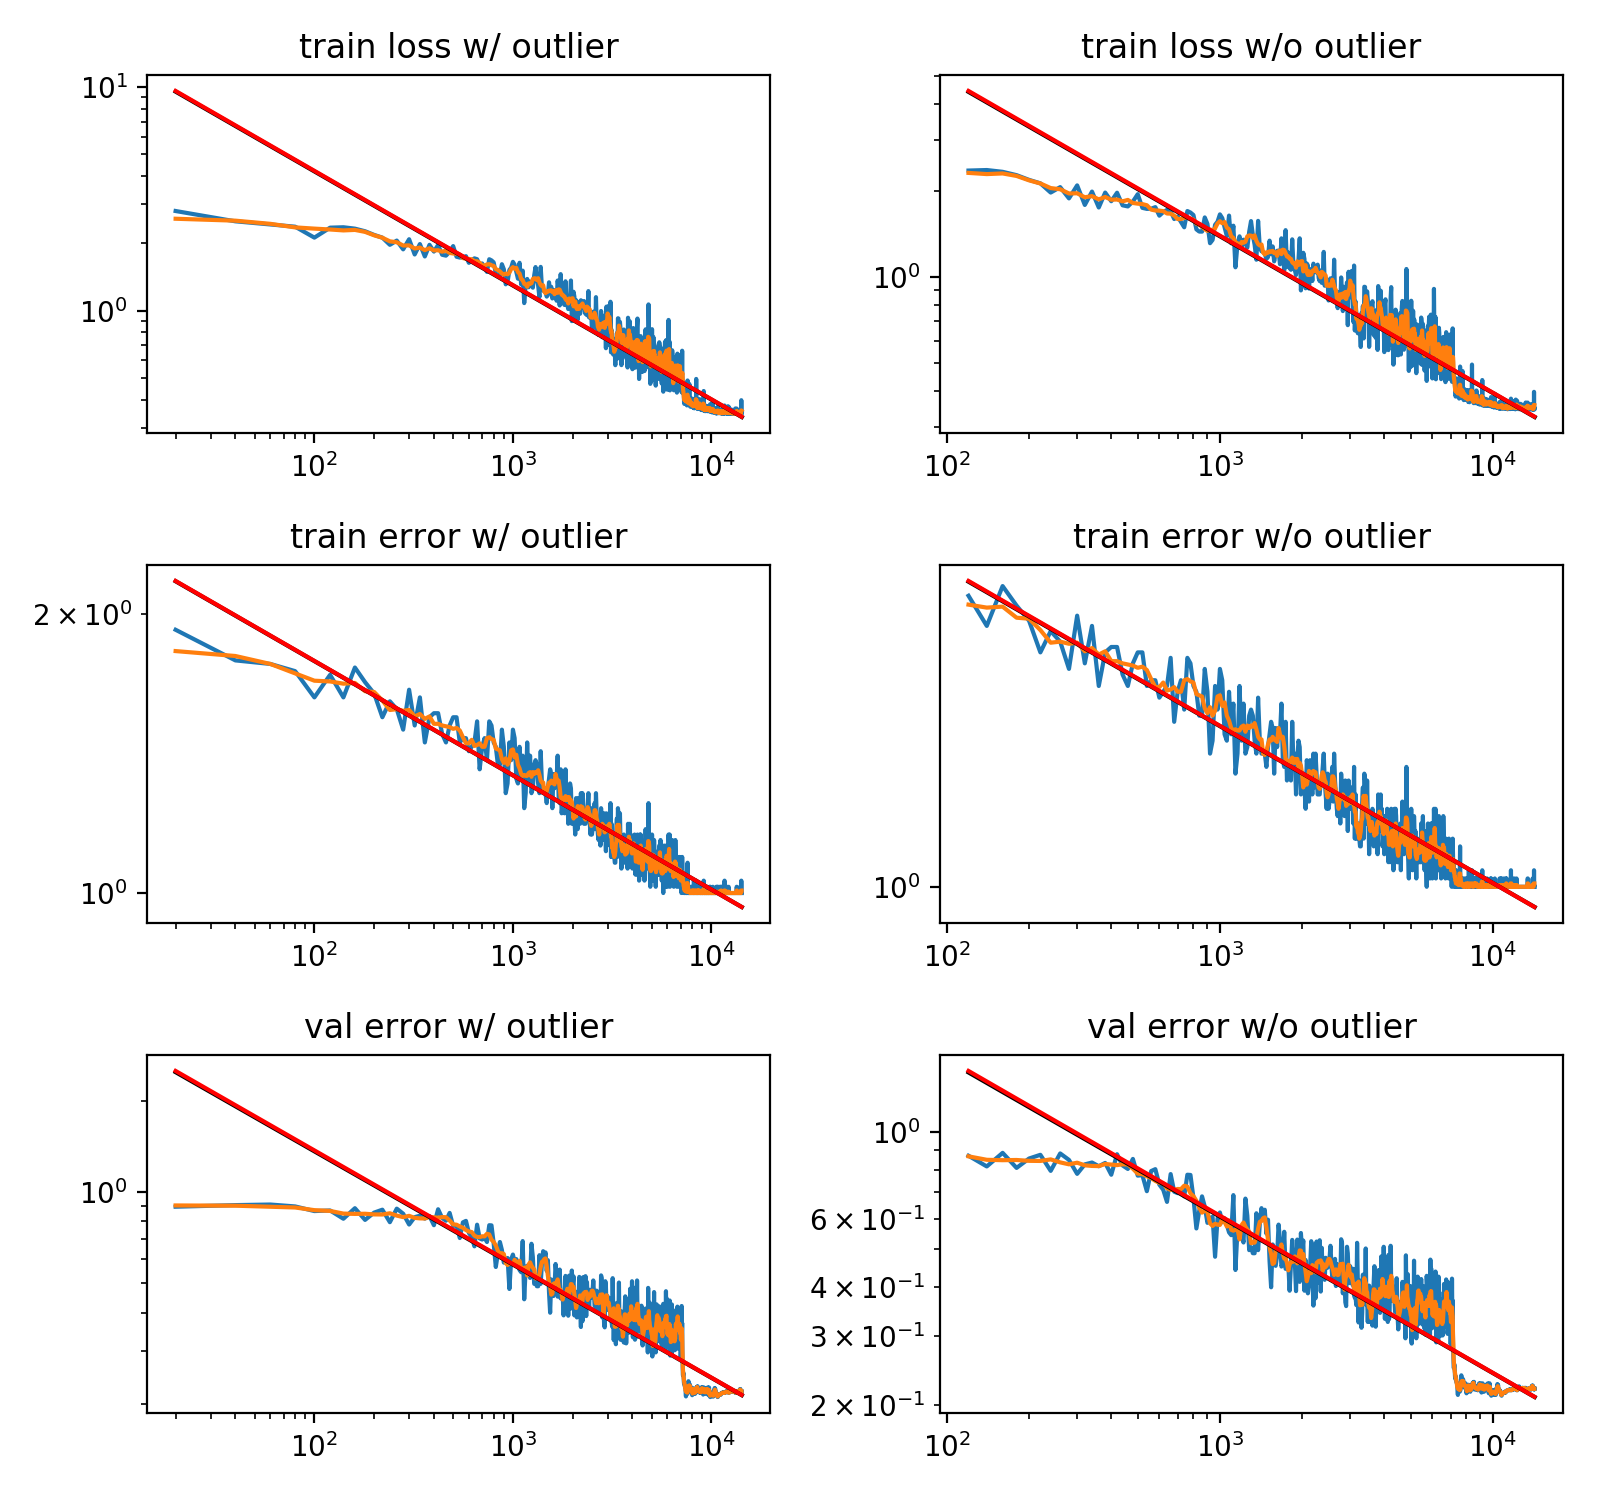

keep the outliers
log(epoch) vs log(train loss): (-0.9615753453081098, 0.0)
log(epoch) vs log(train error): (-0.9808523550794119, 0.0)
log(epoch) vs log(val error): (-0.9374353502916862, 0.0)
delete the outliers
log(epoch) vs log(train loss): (-0.9734301052953437, 0.0)
log(epoch) vs log(train error): (-0.9817266365025094, 0.0)
log(epoch) vs log(val error): (-0.9491428225004813, 0.0)


In [5]:
"""
do linear regression and draw the line
base='linear': do linear regression on x and y
base='log': do linear regression on log10 x and log10 y
draw: if draw the line on axes

return the coefficient and bias
"""
def draw_linear_reg_line(x, y, axes, base='log', draw=True, color='red'):
    if base == 'log':
        A = np.vstack([np.log10(x), np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, np.log10(y), rcond=None)[0]
        if draw:
            axes.plot(x, np.power(10, m*np.log10(x)+c), color=color)
    elif base == 'linear':
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        if draw:
            axes.plot(x, m*x+c, color=color)
    return m,c

'''
log Loss or log Accuracy v.s. log epoch
'''
bias_loss = 0 # y = b+a*x^c
bias_err = -1 # train accuracy bias
bias_verr = 0 # validation accuracy bias

bloss = loss -bias_loss
berr = err-bias_err
bval_err = val_err - bias_verr
bloss_smoothed = loss_smoothed -bias_loss
berr_smoothed = err_smoothed-bias_err
bval_err_smoothed = val_err_smoothed-bias_verr

fig = plt.figure('loglog based. unsmoothed, smoothed, and their regressions', figsize = (8,7.5))
axes_loss = plt.subplot(321)
axes_acc = plt.subplot(323)
axes_val_acc = plt.subplot(325)
# draw the unsmoothed points
axes_loss.loglog(epochs, bloss)
axes_acc.loglog(epochs, berr)
axes_val_acc.loglog(epochs, bval_err)
# draw the smoothed points
axes_loss.loglog(epochs_smoothed, bloss_smoothed)
axes_acc.loglog(epochs_smoothed, berr_smoothed)
axes_val_acc.loglog(epochs_smoothed, bval_err_smoothed)
# set the title
axes_loss.set_title('train loss w/ outlier')
axes_acc.set_title('train error w/ outlier')
axes_val_acc.set_title('val error w/ outlier')

print('keep the outliers')
print("log(epoch) vs log(train loss): {}".format(pearsonr(np.log10(epochs_smoothed), np.log10(bloss_smoothed))))
print("log(epoch) vs log(train error): {}".format(pearsonr(np.log10(epochs_smoothed), np.log10(berr_smoothed))))
print("log(epoch) vs log(val error): {}".format(pearsonr(np.log10(epochs_smoothed), np.log10(bval_err_smoothed))))

# linear regression
## train loss
### w/o smoothing
draw_linear_reg_line(epochs, bloss, axes_loss, color='black')
### w smoothing
draw_linear_reg_line(epochs_smoothed, bloss_smoothed, axes_loss)
## train acc
### w/o smoothing
draw_linear_reg_line(epochs, berr, axes_acc, color='black')
### w smoothing
draw_linear_reg_line(epochs_smoothed, berr_smoothed, axes_acc)
## val acc
### w/o smoothing
draw_linear_reg_line(epochs, bval_err, axes_val_acc, color='black')
### w smoothing
draw_linear_reg_line(epochs_smoothed, bval_err_smoothed, axes_val_acc)



# without outliers
index_begin = 5

epochs_cut = epochs[index_begin:]
epochs_cut_smoothed = epochs_smoothed[index_begin:]
loss_cut =  loss[index_begin:]
err_cut = err[index_begin:]
val_err_cut = val_err[index_begin:]
bloss_cut =  bloss[index_begin:]
berr_cut = berr[index_begin:]
bval_err_cut = bval_err[index_begin:]
bloss_cut_smoothed = bloss_smoothed[index_begin:]
berr_cut_smoothed = berr_smoothed[index_begin:]
bval_err_cut_smoothed = bval_err_smoothed[index_begin:]

axes_loss_wo_outlier = plt.subplot(322)
axes_acc_wo_outlier = plt.subplot(324)
axes_val_acc_wo_outlier = plt.subplot(326)
# draw the unsmoothed points
axes_loss_wo_outlier.loglog(epochs_cut, bloss_cut)
axes_acc_wo_outlier.loglog(epochs_cut, berr_cut)
axes_val_acc_wo_outlier.loglog(epochs_cut, bval_err_cut)
# draw the smoothed points
axes_loss_wo_outlier.loglog(epochs_cut_smoothed, bloss_cut_smoothed)
axes_acc_wo_outlier.loglog(epochs_cut_smoothed, berr_cut_smoothed)
axes_val_acc_wo_outlier.loglog(epochs_cut_smoothed, bval_err_cut_smoothed)
# set the title
axes_loss_wo_outlier.set_title('train loss w/o outlier')
axes_acc_wo_outlier.set_title('train error w/o outlier')
axes_val_acc_wo_outlier.set_title('val error w/o outlier')

print('delete the outliers')
print("log(epoch) vs log(train loss): {}".format(pearsonr(np.log10(epochs_cut_smoothed), np.log10(bloss_cut_smoothed))))
print("log(epoch) vs log(train error): {}".format(pearsonr(np.log10(epochs_cut_smoothed), np.log10(berr_cut_smoothed))))
print("log(epoch) vs log(val error): {}".format(pearsonr(np.log10(epochs_cut_smoothed), np.log10(bval_err_cut_smoothed))))

# linear regression
## train loss
### w/o smoothing
draw_linear_reg_line(epochs_cut, bloss_cut, axes_loss_wo_outlier, color='black')
### w smoothing
draw_linear_reg_line(epochs_cut_smoothed, bloss_cut_smoothed, axes_loss_wo_outlier)
## train acc
### w/o smoothing
draw_linear_reg_line(epochs_cut, berr_cut, axes_acc_wo_outlier, color='black')
### w smoothing
draw_linear_reg_line(epochs_cut_smoothed, berr_cut_smoothed, axes_acc_wo_outlier)
## val acc
### w/o smoothing
draw_linear_reg_line(epochs_cut, bval_err_cut, axes_val_acc_wo_outlier, color='black')
### w smoothing
draw_linear_reg_line(epochs_cut_smoothed, bval_err_cut_smoothed, axes_val_acc_wo_outlier)

fig.tight_layout()

<IPython.core.display.Javascript object>


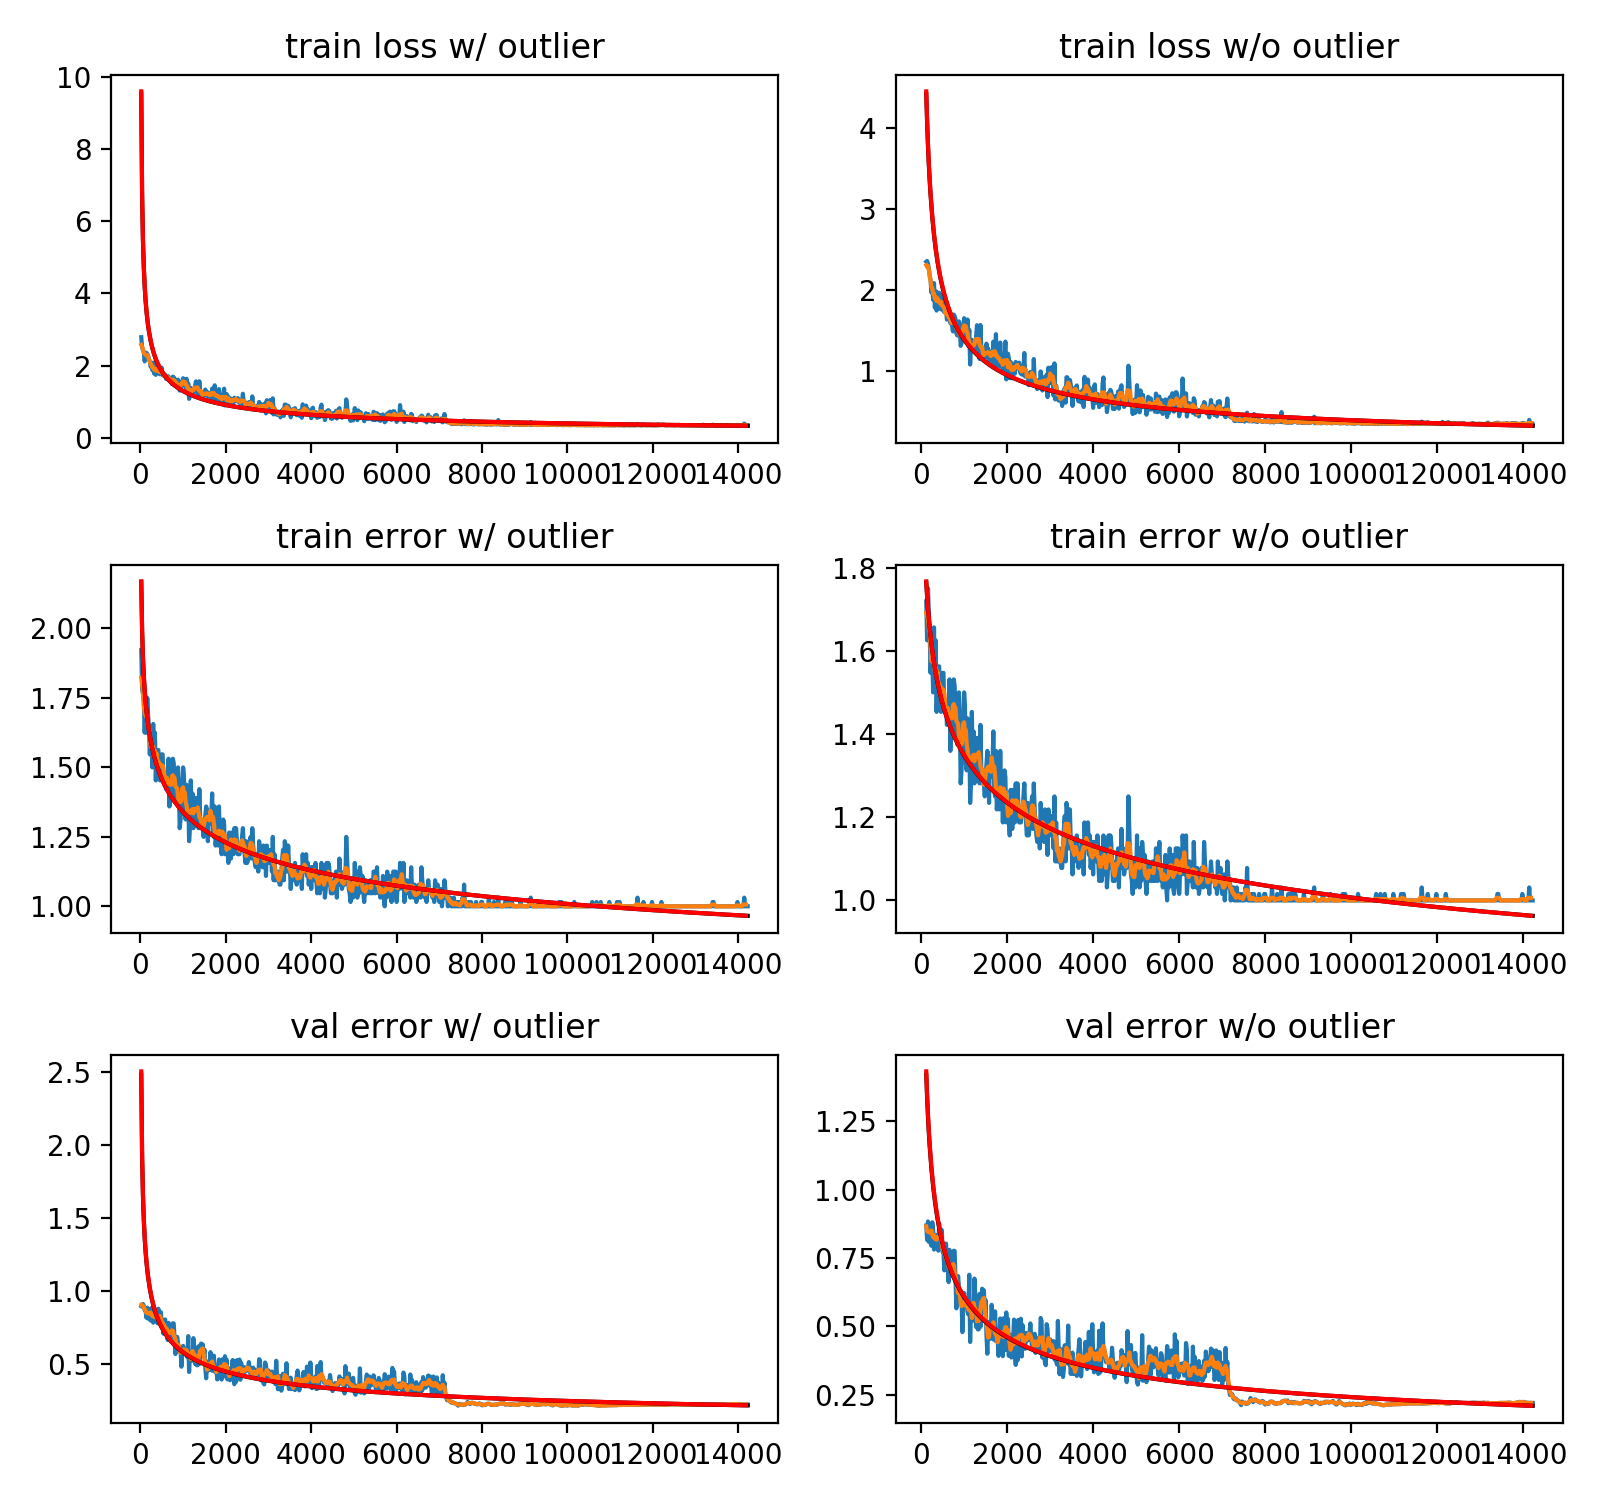

In [6]:
'''
log Loss or log Accuracy v.s. log epoch
'''
fig = plt.figure('original based. unsmoothed, smoothed, and their regressions', figsize = (8,7.5))
axes_loss = plt.subplot(321)
axes_acc = plt.subplot(323)
axes_val_acc = plt.subplot(325)
axes_loss.plot(epochs, bloss)
axes_acc.plot(epochs, berr)
axes_val_acc.plot(epochs, bval_err)
axes_loss.plot(epochs_smoothed, bloss_smoothed)
axes_acc.plot(epochs_smoothed, berr_smoothed)
axes_val_acc.plot(epochs_smoothed, bval_err_smoothed)
axes_loss.set_title('train loss w/ outlier')
axes_acc.set_title('train error w/ outlier')
axes_val_acc.set_title('val error w/ outlier')


# linear regression
## train loss
### w/o smoothing
draw_linear_reg_line(epochs, bloss, axes_loss, color='black')
### w smoothing
draw_linear_reg_line(epochs_smoothed, bloss_smoothed, axes_loss)
## train acc
### w/o smoothing
draw_linear_reg_line(epochs, berr, axes_acc, color='black')
### w smoothing
draw_linear_reg_line(epochs_smoothed, berr_smoothed, axes_acc)
## val acc
### w/o smoothing
draw_linear_reg_line(epochs, bval_err, axes_val_acc, color='black')
### w smoothing
draw_linear_reg_line(epochs_smoothed, bval_err_smoothed, axes_val_acc)

# without outliers
axes_loss_wo_outlier = plt.subplot(322)
axes_acc_wo_outlier = plt.subplot(324)
axes_val_acc_wo_outlier = plt.subplot(326)
axes_loss_wo_outlier.plot(epochs_cut, bloss_cut)
axes_acc_wo_outlier.plot(epochs_cut, berr_cut)
axes_val_acc_wo_outlier.plot(epochs_cut, bval_err_cut)
axes_loss_wo_outlier.plot(epochs_cut_smoothed, bloss_cut_smoothed)
axes_acc_wo_outlier.plot(epochs_cut_smoothed, berr_cut_smoothed)
axes_val_acc_wo_outlier.plot(epochs_cut_smoothed, bval_err_cut_smoothed)
axes_loss_wo_outlier.set_title('train loss w/o outlier')
axes_acc_wo_outlier.set_title('train error w/o outlier')
axes_val_acc_wo_outlier.set_title('val error w/o outlier')


# linear regression
## train loss
### w/o smoothing
draw_linear_reg_line(epochs_cut, bloss_cut, axes_loss_wo_outlier, color='black')
### w smoothing
draw_linear_reg_line(epochs_cut_smoothed, bloss_cut_smoothed, axes_loss_wo_outlier)
## train acc
### w/o smoothing
draw_linear_reg_line(epochs_cut, berr_cut, axes_acc_wo_outlier, color='black')
### w smoothing
draw_linear_reg_line(epochs_cut_smoothed, berr_cut_smoothed, axes_acc_wo_outlier)
## val acc
### w/o smoothing
draw_linear_reg_line(epochs_cut, bval_err_cut, axes_val_acc_wo_outlier, color='black')
### w smoothing
draw_linear_reg_line(epochs_cut_smoothed, bval_err_cut_smoothed, axes_val_acc_wo_outlier)

# print(linear_reg_params)
fig.tight_layout()

<IPython.core.display.Javascript object>


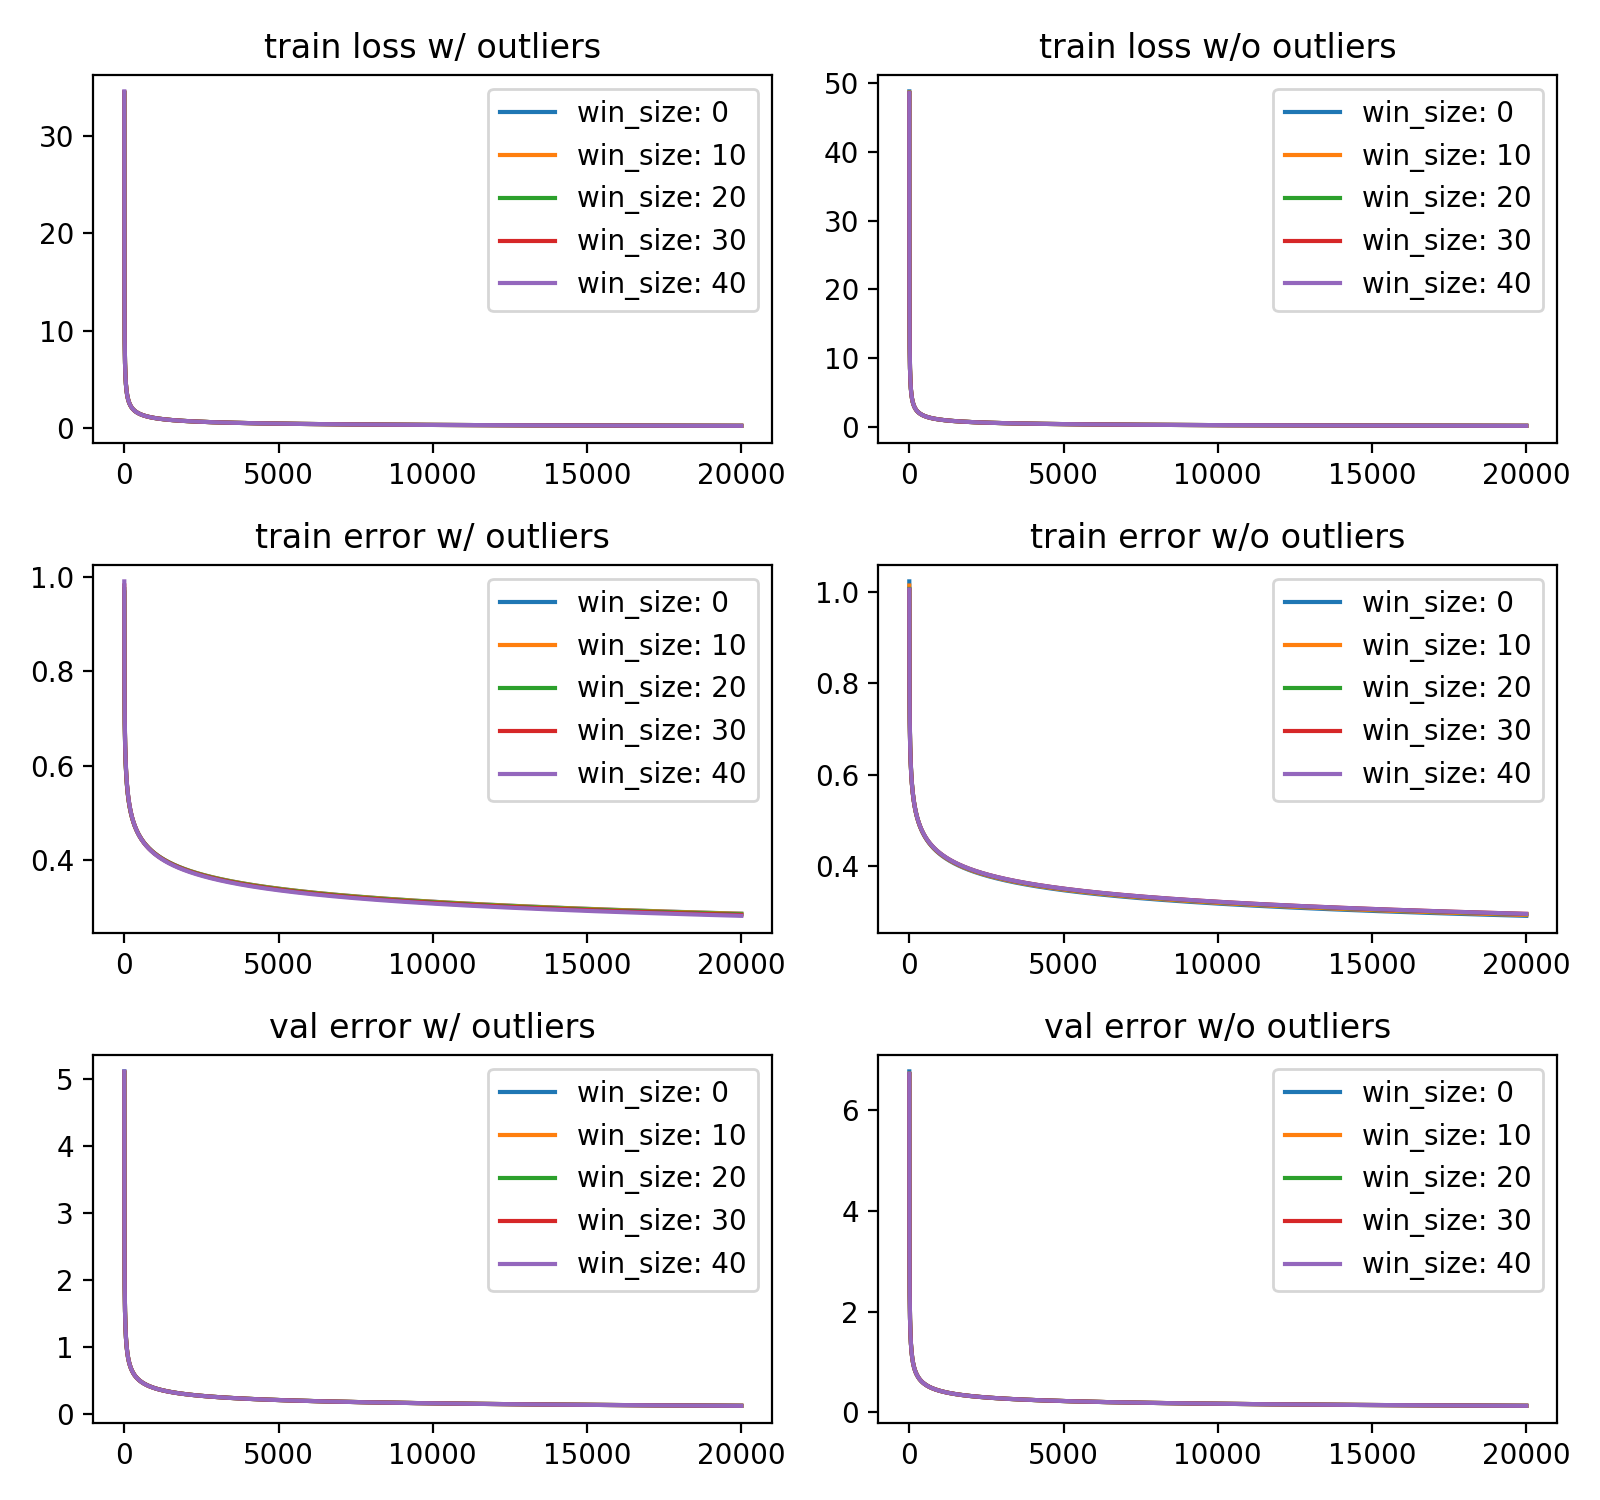

In [7]:
"""
The difference between the regression lines of unsmoothed data and of smoothed data, unsmoothed - smoothed
the input ob_interval here is the observation interval, unnecessarily the real epochs
"""

def draw_diff_bw_regs(axes_list, smooth_win_size, ob_interval=(1,len(epochs)+1)):
    loss_smoothed = smooth_by_linear_filter(loss, smooth_win_size, win_type=win_type)
    err_smoothed = smooth_by_linear_filter(err, smooth_win_size, win_type=win_type)
    val_err_smoothed = smooth_by_linear_filter(val_err, smooth_win_size,win_type=win_type)
    
    epochs_smoothed = range(1, len(loss_smoothed)+1)    
    bloss_smoothed = loss_smoothed -bias_loss
    berr_smoothed = err_smoothed-bias_err
    bval_err_smoothed = val_err_smoothed-bias_verr
    
    epochs_cut_smoothed = epochs_smoothed[index_begin:]
    bloss_cut_smoothed = bloss_smoothed[index_begin:]
    berr_cut_smoothed = berr_smoothed[index_begin:]
    bval_err_cut_smoothed = bval_err_smoothed[index_begin:]
    
    epochs_observe = range(ob_interval[0],ob_interval[1])
        
    axes_loss = axes_list[0]
    m1,c1 = draw_linear_reg_line(epochs, bloss, axes_loss, draw=False)
    m2,c2 = draw_linear_reg_line(epochs_smoothed, bloss_smoothed, axes_loss, draw=False)
    temp = np.power(10,m1*np.log10(epochs_observe)+c1) - np.power(10,m2*np.log10(epochs_observe)+c2)
    axes_loss.plot(epochs_observe, temp, label='win_size: {}'.format(smooth_win_size))
    axes_loss.set_title('train loss w/ outliers')

    axes_err = axes_list[1]
    m1,c1 = draw_linear_reg_line(epochs, berr, axes_err, draw=False)
    m2,c2 = draw_linear_reg_line(epochs_smoothed, berr_smoothed, axes_err, draw=False)
    temp = np.power(10,m1*np.log10(epochs_observe)+c1) - np.power(10,m2*np.log10(epochs_observe)+c2)
    axes_err.plot(epochs_observe, temp, label='win_size: {}'.format(smooth_win_size))
    axes_err.set_title('train error w/ outliers')

    axes_val_err = axes_list[2]
    m1,c1 = draw_linear_reg_line(epochs, bval_err, axes_val_err, draw=False)
    m2,c2 = draw_linear_reg_line(epochs_smoothed, bval_err_smoothed, axes_val_err, draw=False)
    temp = np.power(10,m1*np.log10(epochs_observe)+c1) - np.power(10,m2*np.log10(epochs_observe)+c2)
    axes_val_err.plot(epochs_observe, temp, label='win_size: {}'.format(smooth_win_size))
    axes_val_err.set_title('val error w/ outliers')

    axes_loss_wo_outlier = axes_list[3]
    m1,c1 = draw_linear_reg_line(epochs_cut, bloss_cut, axes_loss_wo_outlier,draw=False)
    m2,c2 = draw_linear_reg_line(epochs_cut_smoothed, bloss_cut_smoothed, axes_loss_wo_outlier,draw=False)
    temp = np.power(10,m1*np.log10(epochs_observe)+c1) - np.power(10,m2*np.log10(epochs_observe)+c2)
    axes_loss_wo_outlier.plot(epochs_observe, temp, label='win_size: {}'.format(smooth_win_size))
    axes_loss_wo_outlier.set_title('train loss w/o outliers')

    axes_err_wo_outlier = axes_list[4]
    m1,c1 = draw_linear_reg_line(epochs_cut, berr_cut, axes_err_wo_outlier, draw=False)
    m2,c2 = draw_linear_reg_line(epochs_cut_smoothed, berr_cut_smoothed, axes_err_wo_outlier,draw=False)
    temp = np.power(10,m1*np.log10(epochs_observe)+c1) - np.power(10,m2*np.log10(epochs_observe)+c2)
    axes_err_wo_outlier.plot(epochs_observe, temp, label='win_size: {}'.format(smooth_win_size))
    axes_err_wo_outlier.set_title('train error w/o outliers')
    fig.tight_layout()

    axes_val_err_wo_outlier = axes_list[5]
    m1,c1 = draw_linear_reg_line(epochs_cut, bval_err_cut, axes_val_err_wo_outlier, draw=False)
    m2,c2 = draw_linear_reg_line(epochs_cut_smoothed, bval_err_cut_smoothed, axes_val_err_wo_outlier,draw=False)
    temp = np.power(10,m1*np.log10(epochs_observe)+c1) - np.power(10,m2*np.log10(epochs_observe)+c2)
    axes_val_err_wo_outlier.plot(epochs_observe, temp, label='win_size: {}'.format(smooth_win_size))
    axes_val_err_wo_outlier.set_title('val error w/o outliers')
    fig.tight_layout()

    
fig = plt.figure('The difference between the regression lines of unsmoothed data and of smoothed data, unsmoothed - smoothed',
                figsize = (8,7.5), )
axes_list = []
for i in range(2):
    for j in range(3):
        axes_list.append(plt.subplot(3,2,i+j*2+1))

# let's predict some future epochs
for win_size in range(0,50,10):
    draw_diff_bw_regs(axes_list, win_size, ob_interval=(1, 20001))
    
for i in range(6):
    axes_list[i].legend()


# temp11 = linear_reg_params[0][0]*np.log10(epochs_smoothed)+linear_reg_params[0][1] \
#         - linear_reg_params[1][0]*np.log10(epochs_smoothed)+linear_reg_params[1][1]
# axes_loss.plot(epochs_smoothed, temp11)


<IPython.core.display.Javascript object>


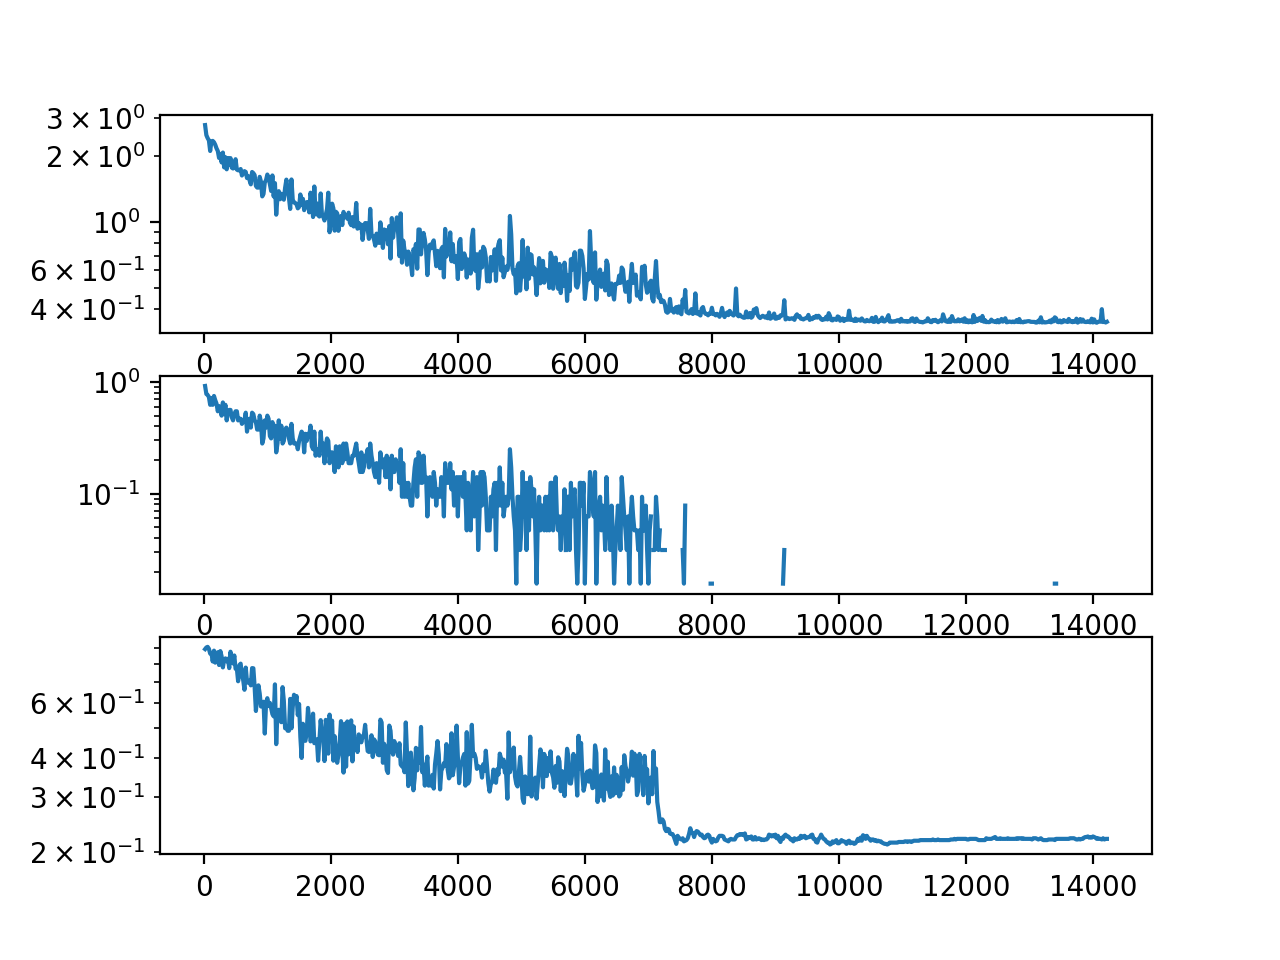

epoch vs log(train loss): (-0.9079136742950491, 6.074834349371666e-270)
epoch vs log(train error): (nan, 1.0)
epoch vs log(val error): (-0.8973872858490688, 3.9851985955813286e-254)


/Users/stranot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/stranot/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3018: RuntimeWarning: invalid value encountered in subtract
  xm, ym = x - mx, y - my
/Users/stranot/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3019: RuntimeWarning: invalid value encountered in multiply
  r_num = np.add.reduce(xm * ym)
/Users/stranot/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3019: RuntimeWarning: invalid value encountered in reduce
  r_num = np.add.reduce(xm * ym)


<IPython.core.display.Javascript object>


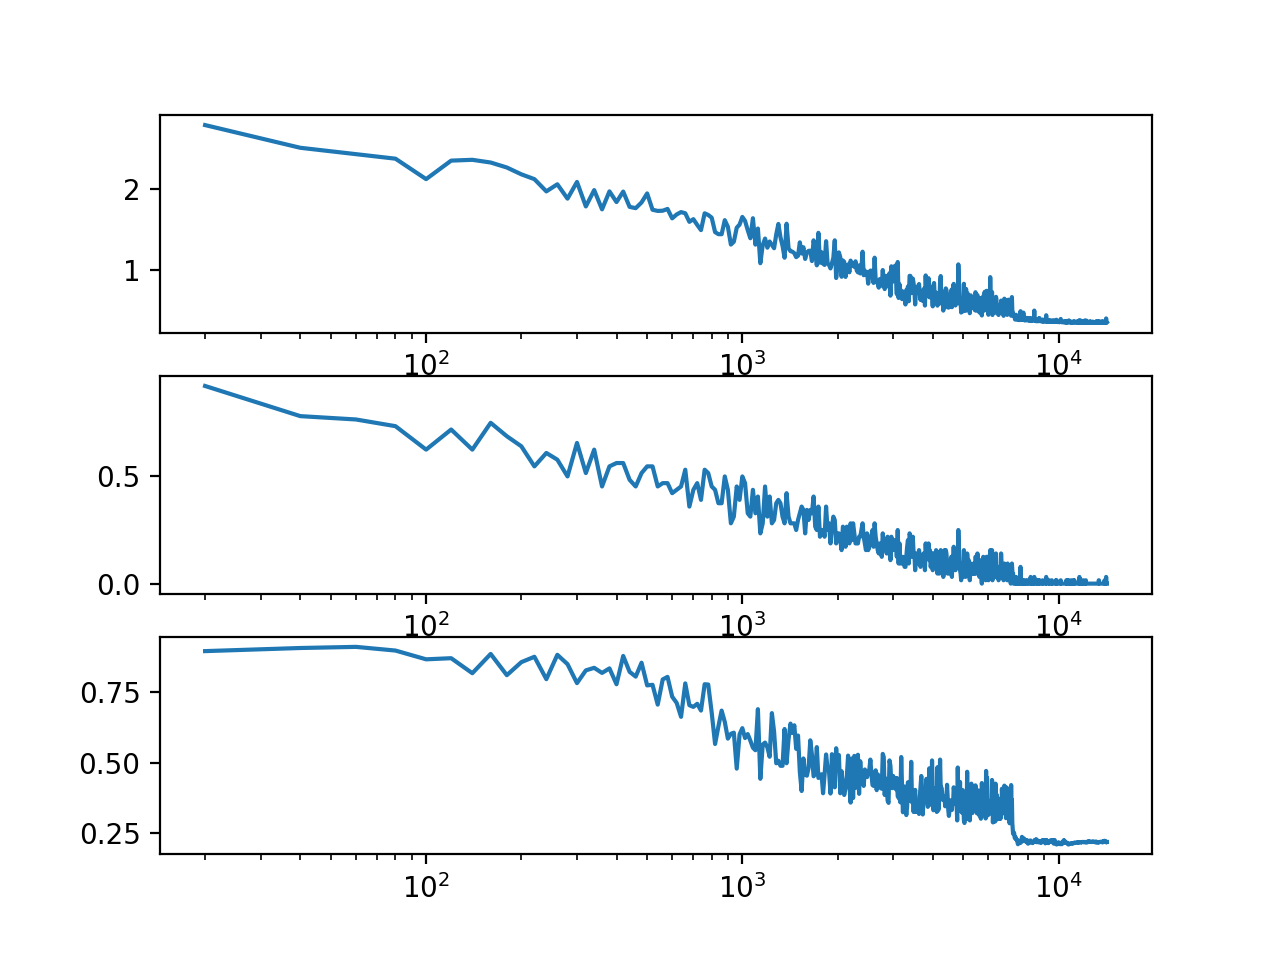

log(epoch) vs train loss: (-0.9739855410420122, 0.0)
log(epoch) vs train error: (-0.9627944592656723, 0.0)
log(epoch) vs val error: (-0.9523489165487513, 0.0)


In [8]:
'''
log Loss or log Accuracy v.s. epoch
'''
plt.figure()
axes_loss = plt.subplot(311)
axes_acc = plt.subplot(312)
axes_val_acc = plt.subplot(313)
axes_loss.semilogy(epochs, loss)
axes_acc.semilogy(epochs, err)
axes_val_acc.semilogy(epochs, val_err)
print("epoch vs log(train loss): {}".format(pearsonr(epochs, np.log10(loss))))
print("epoch vs log(train error): {}".format(pearsonr(epochs, np.log10(err))))
print("epoch vs log(val error): {}".format(pearsonr(epochs, np.log10(val_err))))

# It's not exponential model

plt.figure()
axes_loss = plt.subplot(311)
axes_acc = plt.subplot(312)
axes_val_acc = plt.subplot(313)
axes_loss.semilogx(epochs, loss)
axes_acc.semilogx(epochs, err)
axes_val_acc.semilogx(epochs, val_err)
print("log(epoch) vs train loss: {}".format(pearsonr(np.log10(epochs), loss)))
print("log(epoch) vs train error: {}".format(pearsonr(np.log10(epochs), err)))
print("log(epoch) vs val error: {}".format(pearsonr(np.log10(epochs), val_err)))

